In [1]:
from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from statsmodels.tools import eval_measures
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from fbprophet import Prophet

%matplotlib inline
plt.rcParams['figure.figsize']= (8,8)

from warnings import filterwarnings
filterwarnings('ignore')

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
train_features = pd.read_csv('./data/dengue_features_train.csv', index_col=[0,1,2])
train_labels = pd.read_csv('./data/dengue_labels_train.csv', index_col=[0,1,2])


In [3]:
def preprocess_data(train_features, train_labels=None):
    df = train_features.copy()
    
    features = ['station_max_temp_c', 
                 'station_min_temp_c', 
                 'station_avg_temp_c', 
                 'precipitation_amt_mm', 
                 'reanalysis_dew_point_temp_k', 
                 'reanalysis_air_temp_k', 
                 'reanalysis_relative_humidity_percent',
                 'reanalysis_precip_amt_kg_per_m2', 
                 'ndvi_se', 
                 'ndvi_ne', 
                 'station_precip_mm', 
                 'week_start_date']
    
    df = df[features]
    df.fillna(method='ffill', inplace=True)

    
    if train_labels is not None:
        labels = train_labels
        df = df.join(labels)
        
   
    celsius_list = ['station_max_temp_c', 'station_min_temp_c', 'station_avg_temp_c' ]
    for col in celsius_list:
        df[col] = df[col] + 273.15
    df = df.rename(columns = { name : name[:-2] + '_k' for name in celsius_list })
    
    sj = df.loc['sj']
    iq = df.loc['iq']
    
    return sj, iq

In [4]:
sj_train, iq_train = preprocess_data(train_features, train_labels)

sj_train_subtrain = sj_train.head(800)
sj_train_subtest = sj_train.tail(sj_train.shape[0] - 800)

iq_train_subtrain = iq_train.head(400)
iq_train_subtest = iq_train.tail(iq_train.shape[0] - 400)

In [5]:
train_data = sj_train[['week_start_date', 'total_cases']]
train_data.columns = ['ds', 'y']

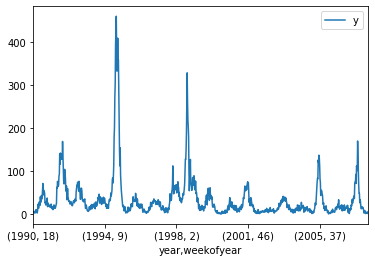

In [6]:
train_data.plot()

In [7]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [8]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [11]:
# load the dataset
dataset = train_data.drop(columns=["ds"]).values
dataset = dataset.astype('float32')

In [12]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [13]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

627 309


In [14]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [15]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [16]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [18]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
 - 2s - loss: 0.0141
Epoch 2/10
 - 1s - loss: 0.0106
Epoch 3/10
 - 1s - loss: 0.0064
Epoch 4/10
 - 1s - loss: 0.0028
Epoch 5/10
 - 1s - loss: 0.0013
Epoch 6/10
 - 1s - loss: 0.0012
Epoch 7/10
 - 1s - loss: 0.0011
Epoch 8/10
 - 1s - loss: 0.0011
Epoch 9/10
 - 1s - loss: 0.0012
Epoch 10/10
 - 1s - loss: 0.0011


In [19]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 16.21 RMSE
Test Score: 10.35 RMSE


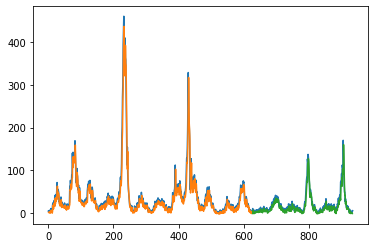

In [20]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [47]:
def moving_test_window_preds(n_future_preds):

    ''' n_future_preds - Represents the number of future predictions we want to make
                         This coincides with the number of windows that we will move forward
                         on the test data
    '''
    preds_moving = []                                    # Use this to store the prediction made on each test window
    moving_test_window = [testX[0,:].tolist()]          # Creating the first test window
    moving_test_window = np.array(moving_test_window)    # Making it an numpy array
    
    for i in range(n_future_preds):
        preds_one_step = model.predict(moving_test_window) # Note that this is already a scaled prediction so no need to rescale this
        preds_moving.append(preds_one_step[0,0]) # get the value from the numpy 2D array and append to predictions
        preds_one_step = preds_one_step.reshape(1,1,1) # Reshaping the prediction to 3D array for concatenation with moving test window
        moving_test_window = np.concatenate((moving_test_window[:,1:,:], preds_one_step), axis=1) # This is the new moving test window, where the first element from the window has been removed and the prediction  has been appended to the end
        
#     preds_moving = scaler.inverse_transform(np.array(preds_moving))
    
    return preds_moving

In [48]:
future = moving_test_window_preds(216)

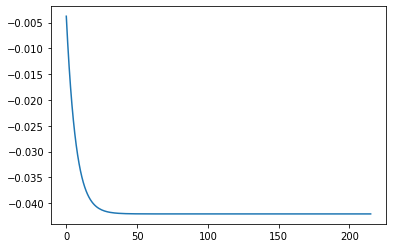

In [49]:
plt.plot(future)